In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import scipy
from scipy.optimize import minimize
from functools import partial

import pickle
import ipywidgets as widgets


In [2]:
from modules.utils import to_latex_table

In [3]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)
    
with open('..//data//men_hours_empirical', 'rb') as f:
    men_hours = pickle.load(f)
    
with open('..//data//women_salary_mean.pkl', 'rb') as f:
    women_salary = pickle.load(f)
    
with open('..//data//men_salary_mean.pkl', 'rb') as f:
    men_salary = pickle.load(f)
    
with open('..//data//fertility.pkl', 'rb') as f:
    fertility = pickle.load(f)
    
with open('..//data//wage_quartiles_empirical_women.pkl', 'rb') as f:
    women_quartiles = pickle.load(f)
    
with open('..//data//wage_quartiles_empirical_men.pkl', 'rb') as f:
    men_quartiles = pickle.load(f)

In [4]:
women_quartiles['upper_quartile']

0    173.97
1    228.85
2    261.74
3    281.90
4    290.65
5    294.12
6    290.68
7    282.47
Name: upper_quartile, dtype: float64

In [5]:
class SalaryProcess:
    
    S_min = 120
    PARAMETERS = {
        'sigma_epsilon'  : 0.15,
        'alpha' :1.2,
        'eta_G'  : 1.2,
        'eta_Z'  : 1.2,
        'eta_G_sq': 0.1,
        'delta'  : 0.1,
    }
    
    def __init__(self, Z=0, G=2, Q=18, sex='women', parameters = PARAMETERS):
        self.Z = Z
        self.G = G
        self.Q = Q
        self.sex = sex
        self.parameters = parameters
        self.Z_hist = list()
        
        # other params
        self.Q_max = 70
        self.Q_min = 18
        
    def reset(self):
        self.Q = 18
        self.G = 2
        self.Z = 0
        
        # temp
        self.Z_hist.append(self.Z)

        
    def step(self):
        
        H = self.H() 
        if self.Q == self.Q_max:
            self.reset()
            H = self.H() 
            
        else:
            
            self.Q = self.Q + 1
            H = self.H() 

            self.G = (1 - self.parameters['delta']) * self.G + H / 37
            self.Z = self.Z + np.random.normal(0, self.parameters['sigma_epsilon'])
            
            # temp
            self.Z_hist.append(self.Z)
            
        S = self.calc_salary()
        return (S, self.Z, self.G, self.Q, H)
            
    def H(self):
        if self.sex=='women':
            if 18 < self.Q < 43:
                p = fertility[self.Q]
                dummy = np.random.binomial(1, p)
                if dummy == 1:
                    return 0.0
        
            return women_hours[self.Q]
        
        elif self.sex=='men':
            return men_hours[self.Q]
        else:
            raise Exception('sex must be either "women" or "men"')
        
    def calc_salary(self):
        log_S_tilde = self.parameters['alpha'] + self.parameters['eta_G'] * self.G + self.parameters['eta_G_sq'] * self.G**2 
        
        
        S_tilde = np.exp(log_S_tilde)
        S = np.max([S_tilde + self.Z, self.S_min])
        if pd.isnull(S):
            print(S_tilde, log_S_tilde, S)
        return S

In [6]:
def plot_wage_process(delta=0.9, alpha=2.3, sigma_epsilon=0.00001, eta_G=0.8, eta_G_sq= 0.1, sex='women'):
    df = simulate(delta, alpha, sigma_epsilon, eta_G, eta_G_sq, sex=sex)
    y_pred = np.array(df.groupby('Q').mean()['S'])
    y_pred_75 = np.array(df.groupby('Q').quantile(0.75)['S'])
    y_pred_25 = np.array(df.groupby('Q').quantile(0.25)['S'])
    
    
    l = len(y_pred)
    size_const = 0.6
    f, ax = plt.subplots(1,1, figsize=(size_const*14, size_const*8))
    ax.plot(range(18, 18 + l),y_pred, label=f'Predicted {sex} wage path')
    ax.fill_between(range(18,18 + l), y_pred_75, y_pred_25, color='C0', alpha=0.25, label='Inter-quartile range')
    
    if sex == 'women':
        ax.plot(women_quartiles['mean_age'], women_quartiles['mean'], label= f'Empirical wage path')
    if sex == 'men':
        ax.plot(men_quartiles['mean_age'], men_quartiles['mean'], label= f'Empirical wage path')
        
    ax.set_title(f'Wage path {sex}, simulated vs. empirical')
    ax.legend()
    
    ax.set_ylabel('wage DKK')
    ax.set_xlabel('age')
    return f

In [7]:
def plot_wage_process_variance(delta=0.9, alpha=2.3, sigma_epsilon=0.00001, eta_G=0.8, eta_G_sq= 0.1, sex='women'):
    df = simulate(delta, alpha, sigma_epsilon, eta_G, eta_G_sq, sex=sex)
    y_pred = np.array(df.groupby('Q').mean()['S'])
    y_pred_75 = np.array(df.groupby('Q').quantile(0.75)['S'])
    y_pred_25 = np.array(df.groupby('Q').quantile(0.25)['S'])
    
    
    l = len(y_pred)
    size_const = 0.6
    f, ax = plt.subplots(1,1, figsize=(size_const*14, size_const*8))
    ax.plot(range(18, 18 + l),y_pred, label=f'Predicted {sex} wage path')
    ax.fill_between(range(18,18 + l), y_pred_75, y_pred_25, color='C0', alpha=0.25, label='Inter-quartile range')
    
    if sex == 'women':
        ax.plot(women_quartiles['mean_age'], women_quartiles['mean'], label= f'Empirical wage path')
        ax.fill_between(women_quartiles['mean_age'], women_quartiles['upper_quartile'], women_quartiles['lower_quartile'], color='C1', alpha=0.25, label='Empirical Inter-quartile range')

    if sex == 'men':
        ax.plot(men_quartiles['mean_age'], men_quartiles['mean'], label= f'Empirical wage path')
        ax.fill_between(men_quartiles['mean_age'], men_quartiles['upper_quartile'], men_quartiles['lower_quartile'], color='C1', alpha=0.25, label='Empirical Inter-quartile range')
        
    ax.set_title(f'Wage path {sex}, simulated vs. empirical')
    ax.legend(loc='upper left')
    
    ax.set_ylabel('wage DKK')
    ax.set_xlabel('age')
    return f

In [8]:
def moment_factory(moment):
    
    if moment=='mean':
        return np.mean
    elif moment=='upper_quartile':
        return lambda x: np.percentile(x, 75)
    elif moment=='lower_quartile':
        return lambda x: np.percentile(x, 25)
    elif moment=='median':
        return lambda x: np.percentile(x, 50)
    else:
        raise Exception('moment does not exist')

In [9]:
def aggregate_moment(df, moment='mean'):
    
    age_groups = [
        (20, 24),
        (25, 29),
        (30, 34),
        (35, 39),
        (40, 44),
        (45, 49),
        (50, 54),
        (55, 59)
    ]
    
    mom_func = moment_factory(moment)
    
    res = list()
    for min_age, max_age in age_groups:
        tmp = df.loc[(df['Q'] >= min_age) & (df['Q'] <= max_age)]
        res.append({'min_age':min_age, 'max_age':max_age, 'mean_age':(min_age + max_age)/ 2, f'{moment}': mom_func(tmp['S'])})
    
    return pd.DataFrame(res)


In [10]:

def simulate(delta=0.1, alpha=2.3, sigma_epsilon=0.00001, eta_G=0.8, eta_G_sq= 0.1, sex='women', N_sims=500, seed_nr=1000):
    
    np.random.seed(seed_nr)
    parameters = {
        'delta': delta,
        'alpha': alpha,
        'sigma_epsilon': sigma_epsilon,
        'eta_G': eta_G,
        'eta_G_sq': eta_G_sq,
    }
    
    sp = SalaryProcess(parameters = parameters, sex=sex)
    results = list()

    for _ in range((sp.Q_max - sp.Q_min) * N_sims):
    
        res = sp.step()
        results.append(res)
        
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    return df

In [11]:
def _calc_metric(y_pred, sex, moment):
    
    y_pred = y_pred[moment]
    if sex == 'women':
        y_true = women_quartiles[moment]
    elif sex == 'men':
        y_true = men_quartiles[moment]
    else:
        raise Exception('sex must be men or women')
    
    ly_true, ly_pred = len(y_true), len(y_pred)    
    assert ly_true == ly_pred, print(ly_true, ly_pred)
    return y_true, y_pred
    
def calc_mse(y_pred, sex='women', moment='mean'):
    
    y_true, y_pred = _calc_metric(y_pred, sex, moment)
    mse = np.mean((np.array(y_true) - np.array(y_pred))**2)
    return mse
    
def calc_mae(y_pred, sex='women', moment='mean'):
    y_true, y_pred = _calc_metric(y_pred, sex, moment)
    mse = np.mean(abs(np.array(y_true) - np.array(y_pred)))
    return mse

In [12]:
tmp = simulate(alpha=3.9, eta_G = 0.45, eta_G_sq = -0.015, delta=0.15)
moms = aggregate_moment(tmp, moment='mean')
calc_mae(moms, moment='mean')

95.86051754271921

In [13]:


def obj(x):
    
    parameters = {
        'alpha' : x[0],
        'eta_G'  : x[1],
        'eta_G_sq': x[2],
        'delta'  : x[3],
        'sigma_epsilon': 0.00001
    }
    
    # men result
    tmp = simulate(**parameters, sex='men')
    moms = aggregate_moment(tmp, moment='mean')
    men_mse = calc_mse(moms, moment='mean', sex='men')
    
    # women result
    
    tmp = simulate(**parameters)
    moms = aggregate_moment(tmp, moment='mean')
    women_mse = calc_mse(moms, moment='mean')
    
    mse = (men_mse + women_mse) / 2
    
    print('')
    print(f'(MSE) combined: {mse:.1f}, men: {men_mse:.1f}, women: {women_mse:.1f}')
    print(parameters)

    
    return mse

In [14]:
x0 = [4.0, 0.5, 0.01, 0.7]
bounds = [(0.1, None), (-1, 3), (-1, 3), (-0.2, 0.5)]
sol = minimize(obj, x0, options={'maxiter':100}, bounds=bounds)




(MSE) combined: 13833.8, men: 16833.5, women: 10834.0
{'alpha': 4.0, 'eta_G': 0.5, 'eta_G_sq': 0.01, 'delta': 0.5, 'sigma_epsilon': 1e-05}

(MSE) combined: 13833.7, men: 16833.5, women: 10834.0
{'alpha': 4.00000001, 'eta_G': 0.5, 'eta_G_sq': 0.01, 'delta': 0.5, 'sigma_epsilon': 1e-05}

(MSE) combined: 13833.7, men: 16833.5, women: 10834.0
{'alpha': 4.0, 'eta_G': 0.50000001, 'eta_G_sq': 0.01, 'delta': 0.5, 'sigma_epsilon': 1e-05}

(MSE) combined: 13833.7, men: 16833.5, women: 10834.0
{'alpha': 4.0, 'eta_G': 0.5, 'eta_G_sq': 0.01000001, 'delta': 0.5, 'sigma_epsilon': 1e-05}

(MSE) combined: 13833.8, men: 16833.5, women: 10834.0
{'alpha': 4.0, 'eta_G': 0.5, 'eta_G_sq': 0.01, 'delta': 0.50000001, 'sigma_epsilon': 1e-05}

(MSE) combined: 14436.3, men: 15263.8, women: 13608.9
{'alpha': 4.9999999908806885, 'eta_G': 0.5000852631996018, 'eta_G_sq': 0.01010197478672375, 'delta': 0.4999761263041115, 'sigma_epsilon': 1e-05}

(MSE) combined: 14436.3, men: 15263.8, women: 13608.9
{'alpha': 5.000000


(MSE) combined: 144.1, men: 239.3, women: 48.9
{'alpha': 4.282139193611559, 'eta_G': 0.5208410708110582, 'eta_G_sq': 0.07982036290562416, 'delta': 0.47622588360051504, 'sigma_epsilon': 1e-05}

(MSE) combined: 134.0, men: 198.6, women: 69.4
{'alpha': 4.229518569046832, 'eta_G': 0.5235926976685708, 'eta_G_sq': 0.08916690051881998, 'delta': 0.4745420385893948, 'sigma_epsilon': 1e-05}

(MSE) combined: 134.0, men: 198.6, women: 69.4
{'alpha': 4.229518579046832, 'eta_G': 0.5235926976685708, 'eta_G_sq': 0.08916690051881998, 'delta': 0.4745420385893948, 'sigma_epsilon': 1e-05}

(MSE) combined: 134.0, men: 198.6, women: 69.4
{'alpha': 4.229518569046832, 'eta_G': 0.5235927076685708, 'eta_G_sq': 0.08916690051881998, 'delta': 0.4745420385893948, 'sigma_epsilon': 1e-05}

(MSE) combined: 134.0, men: 198.6, women: 69.4
{'alpha': 4.229518569046832, 'eta_G': 0.5235926976685708, 'eta_G_sq': 0.08916691051881998, 'delta': 0.4745420385893948, 'sigma_epsilon': 1e-05}

(MSE) combined: 134.0, men: 198.6, wom


(MSE) combined: 131.2, men: 155.2, women: 107.1
{'alpha': 4.355544375941248, 'eta_G': 0.32392487238692785, 'eta_G_sq': 0.12450528216942222, 'delta': 0.44046405326258026, 'sigma_epsilon': 1e-05}

(MSE) combined: 131.2, men: 155.2, women: 107.1
{'alpha': 4.355544375941248, 'eta_G': 0.32392486238692786, 'eta_G_sq': 0.12450529216942222, 'delta': 0.44046405326258026, 'sigma_epsilon': 1e-05}

(MSE) combined: 131.2, men: 155.2, women: 107.1
{'alpha': 4.355544375941248, 'eta_G': 0.32392486238692786, 'eta_G_sq': 0.12450528216942222, 'delta': 0.44046406326258025, 'sigma_epsilon': 1e-05}

(MSE) combined: 135.5, men: 126.8, women: 144.3
{'alpha': 4.522437681358713, 'eta_G': 0.09691954382822998, 'eta_G_sq': 0.16012269969720233, 'delta': 0.402540606365934, 'sigma_epsilon': 1e-05}

(MSE) combined: 135.5, men: 126.8, women: 144.3
{'alpha': 4.5224376913587125, 'eta_G': 0.09691954382822998, 'eta_G_sq': 0.16012269969720233, 'delta': 0.402540606365934, 'sigma_epsilon': 1e-05}

(MSE) combined: 135.5, men:


(MSE) combined: 116.1, men: 104.8, women: 127.4
{'alpha': 4.995649178726149, 'eta_G': -0.25211210914080456, 'eta_G_sq': 0.18483636998345107, 'delta': 0.35592727912495203, 'sigma_epsilon': 1e-05}

(MSE) combined: 116.1, men: 104.8, women: 127.4
{'alpha': 4.995649188726149, 'eta_G': -0.25211210914080456, 'eta_G_sq': 0.18483636998345107, 'delta': 0.35592727912495203, 'sigma_epsilon': 1e-05}

(MSE) combined: 116.1, men: 104.8, women: 127.4
{'alpha': 4.995649178726149, 'eta_G': -0.25211209914080457, 'eta_G_sq': 0.18483636998345107, 'delta': 0.35592727912495203, 'sigma_epsilon': 1e-05}

(MSE) combined: 116.1, men: 104.8, women: 127.4
{'alpha': 4.995649178726149, 'eta_G': -0.25211210914080456, 'eta_G_sq': 0.18483637998345107, 'delta': 0.35592727912495203, 'sigma_epsilon': 1e-05}

(MSE) combined: 116.1, men: 104.8, women: 127.4
{'alpha': 4.995649178726149, 'eta_G': -0.25211210914080456, 'eta_G_sq': 0.18483636998345107, 'delta': 0.35592728912495203, 'sigma_epsilon': 1e-05}

(MSE) combined: 115


(MSE) combined: 114.3, men: 99.7, women: 129.0
{'alpha': 5.184313098520655, 'eta_G': -0.37774176705186907, 'eta_G_sq': 0.19318898913579846, 'delta': 0.33927409516839835, 'sigma_epsilon': 1e-05}

(MSE) combined: 114.3, men: 99.7, women: 129.0
{'alpha': 5.184313098520655, 'eta_G': -0.37774176705186907, 'eta_G_sq': 0.19318897913579847, 'delta': 0.33927410516839834, 'sigma_epsilon': 1e-05}

(MSE) combined: 114.3, men: 99.6, women: 129.0
{'alpha': 5.194005328817789, 'eta_G': -0.3827849873777858, 'eta_G_sq': 0.1928532932235104, 'delta': 0.33801274442079876, 'sigma_epsilon': 1e-05}

(MSE) combined: 114.3, men: 99.6, women: 129.0
{'alpha': 5.194005338817789, 'eta_G': -0.3827849873777858, 'eta_G_sq': 0.1928532932235104, 'delta': 0.33801274442079876, 'sigma_epsilon': 1e-05}

(MSE) combined: 114.3, men: 99.6, women: 129.0
{'alpha': 5.194005328817789, 'eta_G': -0.38278497737778583, 'eta_G_sq': 0.1928532932235104, 'delta': 0.33801274442079876, 'sigma_epsilon': 1e-05}

(MSE) combined: 114.3, men: 9


(MSE) combined: 375.8, men: 489.4, women: 262.2
{'alpha': 4.657582612588195, 'eta_G': 0.149381273084554, 'eta_G_sq': 0.034903251602248275, 'delta': 0.2779367736262873, 'sigma_epsilon': 1e-05}

(MSE) combined: 375.8, men: 489.4, women: 262.2
{'alpha': 4.657582602588195, 'eta_G': 0.149381283084554, 'eta_G_sq': 0.034903251602248275, 'delta': 0.2779367736262873, 'sigma_epsilon': 1e-05}

(MSE) combined: 375.8, men: 489.4, women: 262.2
{'alpha': 4.657582602588195, 'eta_G': 0.149381273084554, 'eta_G_sq': 0.03490326160224828, 'delta': 0.2779367736262873, 'sigma_epsilon': 1e-05}

(MSE) combined: 375.8, men: 489.4, women: 262.2
{'alpha': 4.657582602588195, 'eta_G': 0.149381273084554, 'eta_G_sq': 0.034903251602248275, 'delta': 0.2779367836262873, 'sigma_epsilon': 1e-05}

(MSE) combined: 108.2, men: 98.0, women: 118.5
{'alpha': 4.938198670247497, 'eta_G': -0.1112949825852737, 'eta_G_sq': 0.10948955298435659, 'delta': 0.307137484847654, 'sigma_epsilon': 1e-05}

(MSE) combined: 108.2, men: 98.0, wo


(MSE) combined: 99.5, men: 77.8, women: 121.3
{'alpha': 4.616136493653328, 'eta_G': 0.13013709468646648, 'eta_G_sq': 0.05022505233221363, 'delta': 0.27762027995626126, 'sigma_epsilon': 1e-05}

(MSE) combined: 97.0, men: 64.3, women: 129.7
{'alpha': 4.738054440318877, 'eta_G': 0.04787935417814829, 'eta_G_sq': 0.05797066111058123, 'delta': 0.2650637280643361, 'sigma_epsilon': 1e-05}

(MSE) combined: 97.0, men: 64.3, women: 129.7
{'alpha': 4.738054450318877, 'eta_G': 0.04787935417814829, 'eta_G_sq': 0.05797066111058123, 'delta': 0.2650637280643361, 'sigma_epsilon': 1e-05}

(MSE) combined: 97.0, men: 64.3, women: 129.7
{'alpha': 4.738054440318877, 'eta_G': 0.04787936417814829, 'eta_G_sq': 0.05797066111058123, 'delta': 0.2650637280643361, 'sigma_epsilon': 1e-05}

(MSE) combined: 97.0, men: 64.3, women: 129.7
{'alpha': 4.738054440318877, 'eta_G': 0.04787935417814829, 'eta_G_sq': 0.05797067111058123, 'delta': 0.2650637280643361, 'sigma_epsilon': 1e-05}

(MSE) combined: 97.0, men: 64.3, women


(MSE) combined: 92.1, men: 53.5, women: 130.8
{'alpha': 4.800209716673693, 'eta_G': 0.04003750033049209, 'eta_G_sq': 0.04317329881815578, 'delta': 0.23686273605000063, 'sigma_epsilon': 1e-05}

(MSE) combined: 92.1, men: 53.5, women: 130.8
{'alpha': 4.800209716673693, 'eta_G': 0.04003749033049209, 'eta_G_sq': 0.04317330881815578, 'delta': 0.23686273605000063, 'sigma_epsilon': 1e-05}

(MSE) combined: 92.1, men: 53.5, women: 130.8
{'alpha': 4.800209716673693, 'eta_G': 0.04003749033049209, 'eta_G_sq': 0.04317329881815578, 'delta': 0.23686274605000063, 'sigma_epsilon': 1e-05}

(MSE) combined: 90.9, men: 48.2, women: 133.6
{'alpha': 4.777997664781153, 'eta_G': 0.055605080432880885, 'eta_G_sq': 0.038223517846246356, 'delta': 0.2302414099478386, 'sigma_epsilon': 1e-05}

(MSE) combined: 90.9, men: 48.2, women: 133.6
{'alpha': 4.777997674781153, 'eta_G': 0.055605080432880885, 'eta_G_sq': 0.038223517846246356, 'delta': 0.2302414099478386, 'sigma_epsilon': 1e-05}

(MSE) combined: 90.9, men: 48.2,


(MSE) combined: 88.7, men: 46.7, women: 130.7
{'alpha': 4.614325553472668, 'eta_G': 0.1572548665085027, 'eta_G_sq': 0.018727193891684153, 'delta': 0.2170728282270387, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.7, men: 46.7, women: 130.7
{'alpha': 4.614325563472668, 'eta_G': 0.1572548665085027, 'eta_G_sq': 0.018727193891684153, 'delta': 0.2170728282270387, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.7, men: 46.7, women: 130.7
{'alpha': 4.614325553472668, 'eta_G': 0.1572548765085027, 'eta_G_sq': 0.018727193891684153, 'delta': 0.2170728282270387, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.7, men: 46.7, women: 130.7
{'alpha': 4.614325553472668, 'eta_G': 0.1572548665085027, 'eta_G_sq': 0.018727203891684155, 'delta': 0.2170728282270387, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.7, men: 46.7, women: 130.7
{'alpha': 4.614325553472668, 'eta_G': 0.1572548665085027, 'eta_G_sq': 0.018727193891684153, 'delta': 0.21707283822703868, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.6, men: 46.9, women


(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.6088169006656745, 'eta_G': 0.16405141713676266, 'eta_G_sq': 0.014941380618558632, 'delta': 0.20897901628441393, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.6088169006656745, 'eta_G': 0.16405141713676266, 'eta_G_sq': 0.014941370618558632, 'delta': 0.20897902628441392, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609502817401558, 'eta_G': 0.16363684286600683, 'eta_G_sq': 0.015036375845768715, 'delta': 0.20910430709187033, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609502827401558, 'eta_G': 0.16363684286600683, 'eta_G_sq': 0.015036375845768715, 'delta': 0.20910430709187033, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609502817401558, 'eta_G': 0.16363685286600682, 'eta_G_sq': 0.015036375845768715, 'delta': 0.20910430709187033, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 


(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.6094415307809555, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366659659060864, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034013757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084635174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, 


(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780955, 'eta_G': 0.16366658659060931, 'eta_G_sq': 0.015034003757992893, 'delta': 0.20910846351748383, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.6094415307809555, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366659659060864, 'eta_G_sq': 0.015034003757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520780956, 'eta_G': 0.16366658659060865, 'eta_G_sq': 0.015034013757992973, 'delta': 0.2091084535174838, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5,


(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520744154, 'eta_G': 0.16366659645522239, 'eta_G_sq': 0.015034003201216065, 'delta': 0.20910845368951886, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520744154, 'eta_G': 0.1636665864552224, 'eta_G_sq': 0.015034013201216065, 'delta': 0.20910845368951886, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520744154, 'eta_G': 0.1636665864552224, 'eta_G_sq': 0.015034003201216065, 'delta': 0.20910846368951885, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441520773115, 'eta_G': 0.16366658656176322, 'eta_G_sq': 0.015034003639365906, 'delta': 0.20910845355413765, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5, women: 132.4
{'alpha': 4.609441530773115, 'eta_G': 0.16366658656176322, 'eta_G_sq': 0.015034003639365906, 'delta': 0.20910845355413765, 'sigma_epsilon': 1e-05}

(MSE) combined: 88.5, men: 44.5

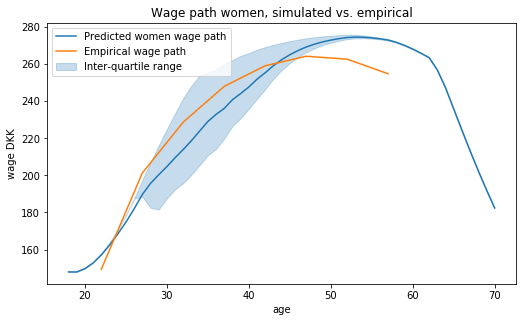

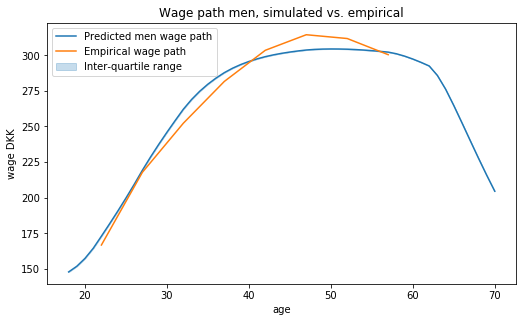

In [15]:
sol_dict = {
    'alpha': sol.x[0],
    'eta_G': sol.x[1],
    'eta_G_sq': sol.x[2],
    'delta': sol.x[3]
}

sol.x
f_women = plot_wage_process(**sol_dict)
f_men = plot_wage_process(**sol_dict,sex='men')


f_women.savefig('..//figures//simulated_wage_path_optimized_parameters_men')
f_men.savefig('..//figures//simulated_wage_path_optimized_parameters_women')

In [16]:
sol
print(sol)

# old_sol5 = {'alpha': 3.7401736198159052, 'eta_G': 0.5487673463960259, 'eta_G_sq': -0.04484104545216317, 'delta': 0.8462938422559253, 'mse': 2.843191841160111}

      fun: 88.45631432264096
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01296598,  0.04729515,  0.19385737, -0.05987744])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 550
      nit: 62
   status: 0
  success: True
        x: array([4.60944152, 0.16366659, 0.015034  , 0.20910845])


In [17]:
#women
tmp = simulate(**sol_dict)
moms = aggregate_moment(tmp, moment='mean')
women_abs_error = calc_mae(moms, moment='mean')
women_abs_error

10.617303465011211

In [18]:
#men
tmp = simulate(**sol_dict, sex='men')
moms = aggregate_moment(tmp, moment='mean')
men_abs_error = calc_mae(moms, moment='mean', sex='men')
men_abs_error

5.841353011178462

In [19]:
with open('..//data//wage_path_parameters_hat.pkl', 'wb') as f:
    pickle.dump(sol_dict, f)

In [20]:
with open('..//data//wage_path_parameters_hat.pkl', 'rb') as f:
    optimal_dict = pickle.load(f)

# Tuning the wage variance

In [21]:
def obj_2(x):
    
    parameters = {key : val for key, val in optimal_dict.items()}
    parameters['sigma_epsilon'] = x[0]    
    
    # men result
    tmp = simulate(**parameters, sex='men')
    moms_upper = aggregate_moment(tmp, moment='upper_quartile')
    moms_lower = aggregate_moment(tmp, moment='lower_quartile')

    men_mse_upper = calc_mse(moms_upper, moment='upper_quartile', sex='men')
    men_mse_lower = calc_mse(moms_lower, moment='lower_quartile', sex='men')
    
    # women result
    
    tmp = simulate(**parameters)
    moms_upper = aggregate_moment(tmp, moment='upper_quartile')
    moms_lower = aggregate_moment(tmp, moment='lower_quartile')

    women_mse_upper = calc_mse(moms_upper, moment='upper_quartile')
    women_mse_lower = calc_mse(moms_lower, moment='lower_quartile')
    
    mse = (men_mse_upper + men_mse_lower + women_mse_upper + women_mse_lower) / 4
    
    print('')
    print('(upper, lower)')
    print(f'(MSE) combined: {mse:.1f}, men : ({men_mse_upper:.1f}, {men_mse_lower}), women : ({women_mse_upper:.1f}, {women_mse_lower})')
    print(parameters)

    
    return mse

In [22]:
x0 = [0.5]
bounds = [(0.0001, None)]
sol_2 = minimize(obj_2, x0, options={'maxiter':100}, bounds=bounds)


(upper, lower)
(MSE) combined: 2248.0, men : (1514.1, 5003.79819541397), women : (402.4, 2071.4750022427525)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 0.5}

(upper, lower)
(MSE) combined: 2248.0, men : (1514.1, 5003.798191830383), women : (402.4, 2071.475000047864)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 0.50000001}

(upper, lower)
(MSE) combined: 2042.1, men : (1327.1, 4595.780595397944), women : (363.9, 1881.5800369524743)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 1.5}

(upper, lower)
(MSE) combined: 2042.1, men : (1327.1, 4595.780591496081), women : (363.9, 1881.580034594332)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma


(upper, lower)
(MSE) combined: 404.6, men : (80.6, 613.4380880644774), women : (822.5, 101.76845262037727)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 15.113201291601047}

(upper, lower)
(MSE) combined: 404.6, men : (80.6, 613.4380865233417), women : (822.5, 101.76845234120064)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 15.113201301601048}

(upper, lower)
(MSE) combined: 404.6, men : (80.5, 613.9526861329372), women : (822.0, 101.86174822797128)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 15.109863034600862}

(upper, lower)
(MSE) combined: 404.6, men : (80.5, 613.9526845910385), women : (822.0, 101.86174794819982)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta'


(upper, lower)
(MSE) combined: 404.6, men : (80.5, 613.9096692643835), women : (822.0, 101.85394351608242)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 15.110142026737947}

(upper, lower)
(MSE) combined: 404.6, men : (80.5, 613.9096708062186), women : (822.0, 101.85394379580451)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 15.110142016737946}

(upper, lower)
(MSE) combined: 404.6, men : (80.5, 613.9096692643835), women : (822.0, 101.85394351608242)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 15.110142026737947}

(upper, lower)
(MSE) combined: 404.6, men : (80.6, 613.4398915408228), women : (822.5, 101.76877932073947)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta'

In [23]:
sol_2

      fun: 404.5836169964359
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.06201617])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 9
   status: 0
  success: True
        x: array([15.11014606])

In [24]:
sol_2_dict = {
    'sigma_epsilon': sol.x[0]
}
with open('..//data//wage_variance_parameters_hat.pkl', 'wb') as f:
    pickle.dump(sol_2_dict, f)

In [25]:
candidates = []
for i in range(1, 20):
    candidates.append([i])

In [26]:
mse_sigma = list()

for sigma in candidates:
    mse = obj_2(sigma)
    mse_sigma.append(mse)


(upper, lower)
(MSE) combined: 2146.5, men : (1421.1, 4799.269881457609), women : (384.1, 1981.648809939285)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 1}

(upper, lower)
(MSE) combined: 1939.8, men : (1233.3, 4398.53044272201), women : (343.5, 1783.8631351962465)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 2}

(upper, lower)
(MSE) combined: 1735.5, men : (1053.7, 4004.1023466494194), women : (309.2, 1574.9455905241987)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 3}

(upper, lower)
(MSE) combined: 1539.9, men : (883.7, 3628.8100192629227), women : (278.2, 1368.9453992501433)
{'alpha': 4.6094415207702, 'eta_G': 0.16366658655104002, 'eta_G_sq': 0.01503400359526669, 'delta': 0.20910845356776359, 'sigma_epsilon': 

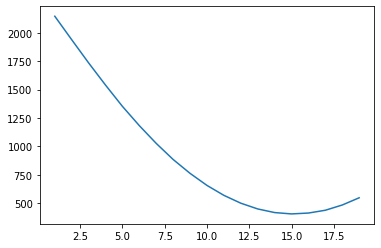

In [27]:
plt.plot(range(1,20), mse_sigma)

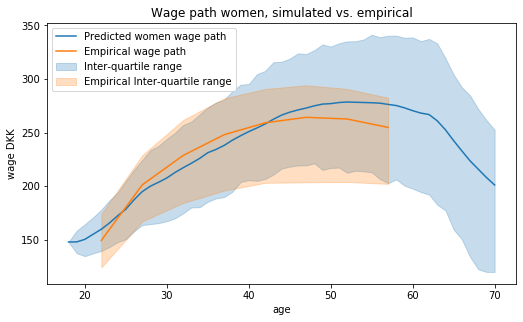

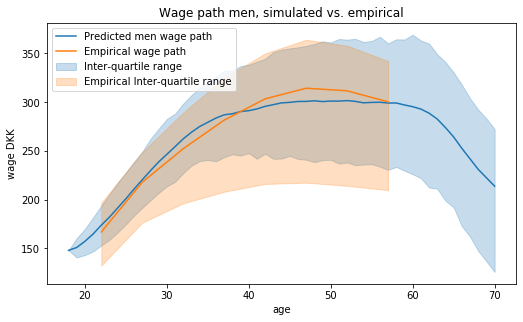

In [28]:
optimal_dict_extended = optimal_dict.copy()
optimal_dict_extended['sigma_epsilon'] = sol_2.x[0]

f_women = plot_wage_process_variance(**optimal_dict_extended)
f_men = plot_wage_process_variance(**optimal_dict_extended,sex='men')

f_women.savefig('..//figures//simulated_wage_path_variance_optimized_parameters_men')
f_men.savefig('..//figures//simulated_wage_path_variance_optimized_parameters_women')

In [29]:
def change_name(name):
    
    if name == 'eta_G_sq':
        name = 'eta_{G^{2}}'
        
    if name == 'sigma_epsilon':
        name = 'sigma_{\epsilon}'

    return '$\hat{' + f'\{name}' + '}$'

parameter_hat = pd.DataFrame([{change_name(key) : value for key, value in optimal_dict_extended.items()}])
parameter_hat.index = ['Parameters']
to_latex_table('..//tables//wage_path_parameters_solved', parameter_hat, nr_decimals=3, index=True)

In [30]:
parameter_hat

,$\hat{\alpha}$,$\hat{\eta_G}$,$\hat{\eta_{G^{2}}}$,$\hat{\delta}$,$\hat{\sigma_{\epsilon}}$
Parameters,4.609442,0.163667,0.015034,0.209108,15.110146
